## Predicting Food Delivery Time

PROBLEM STATEMENT:

* Goal is to predict the online order delivery time based on the given factors.

FEATURES:

* Restaurant: A unique ID that represents a restaurant.
* Location: The location of the restaurant.
* Cuisines: The cuisines offered by the restaurant.
* Average_Cost: The average cost for one person/order.
* Minimum_Order: The minimum order amount.
* Rating: Customer rating for the restaurant.
* Votes: The total number of customer votes for the restaurant.
* Reviews: The number of customer reviews for the restaurant.
* Delivery_Time: The order delivery time of the restaurant. (Target Classes) 

EVALUATION METRIC USED:

The final score will be calculated based on F1 micro due to the high imbalance in the dataset.

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading train and test datasets
train = pd.read_excel('Data_Train.xlsx')
test = pd.read_excel('Data_Test.xlsx')
#Concatenating train and test datasets
data = train.append(test, ignore_index=True,sort=False)

In [3]:
data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",₹200,₹50,3.5,12,4,30 minutes
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",₹100,₹50,3.5,11,4,30 minutes
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",₹150,₹50,3.6,99,30,65 minutes
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",₹250,₹99,3.7,176,95,30 minutes
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",₹200,₹99,3.2,521,235,65 minutes


In [4]:
#Shape of train and test dataset
print("Number of rows in training dataset:",train.shape)
print("Number of rows in testing dataset:",test.shape)
print("Number of rows in whole dataset:",data.shape)

Number of rows in training dataset: (11094, 9)
Number of rows in testing dataset: (2774, 8)
Number of rows in whole dataset: (13868, 9)


In [5]:
#Columns of train dataset
train.columns

Index(['Restaurant', 'Location', 'Cuisines', 'Average_Cost', 'Minimum_Order',
       'Rating', 'Votes', 'Reviews', 'Delivery_Time'],
      dtype='object')

In [6]:
#Check for null values in dataset
data.isnull().sum()

Restaurant          0
Location            0
Cuisines            0
Average_Cost        0
Minimum_Order       0
Rating              0
Votes               0
Reviews             0
Delivery_Time    2774
dtype: int64

In [7]:
data

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",₹200,₹50,3.5,12,4,30 minutes
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",₹100,₹50,3.5,11,4,30 minutes
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",₹150,₹50,3.6,99,30,65 minutes
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",₹250,₹99,3.7,176,95,30 minutes
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",₹200,₹99,3.2,521,235,65 minutes
...,...,...,...,...,...,...,...,...,...
13863,ID_6342,Delhi University-GTB Nagar,"Fast Food, Chinese",₹100,₹50,NEW,-,-,NaN
13864,ID_8495,"Mico Layout, Stage 2, BTM Layout,Bangalore","Continental, North Indian, Desserts, Beverages",₹250,₹50,3.1,5,1,NaN
13865,ID_7122,"Noorkhan Bazaar, Malakpet, Hyderabad","Andhra, South Indian",₹150,₹50,3.0,16,1,NaN
13866,ID_2475,"D-Block, Sector 63, Noida",Bakery,₹100,₹99,3.0,7,2,NaN


In [8]:
#Check for unique values
data.nunique()

Restaurant       8661
Location           35
Cuisines         2392
Average_Cost       26
Minimum_Order      20
Rating             33
Votes            1181
Reviews           811
Delivery_Time       7
dtype: int64

In [9]:
# Check for information about dataset including the index dtype and column dtypes, non-null values and memory usage
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13868 entries, 0 to 13867
Data columns (total 9 columns):
Restaurant       13868 non-null object
Location         13868 non-null object
Cuisines         13868 non-null object
Average_Cost     13868 non-null object
Minimum_Order    13868 non-null object
Rating           13868 non-null object
Votes            13868 non-null object
Reviews          13868 non-null object
Delivery_Time    11094 non-null object
dtypes: object(9)
memory usage: 975.2+ KB


In [10]:
#Check for total number of values in Delivery time(Target variable having 7 classes)
data['Delivery_Time'].value_counts()

30 minutes     7406
45 minutes     2665
65 minutes      923
120 minutes      62
20 minutes       20
80 minutes       14
10 minutes        4
Name: Delivery_Time, dtype: int64

## Data preprocessing 

In [11]:
data['Cuisines'] = data['Cuisines'].str.lower() 
data['Cuisines'] = data['Cuisines'].str.replace(' ','')
Cuisines_list = data['Cuisines'].str.split(',')
from collections import Counter
Cuisines_counter = Counter(([a for b in Cuisines_list.tolist() for a in b]))
Cuisines_counter

Counter({'fastfood': 3862,
         'rolls': 620,
         'burger': 414,
         'salad': 284,
         'wraps': 97,
         'icecream': 480,
         'desserts': 1548,
         'italian': 751,
         'streetfood': 935,
         'mughlai': 1098,
         'northindian': 5999,
         'chinese': 4339,
         'cafe': 592,
         'beverages': 1789,
         'southindian': 1507,
         'thai': 205,
         'asian': 259,
         'mithai': 386,
         'momos': 397,
         'indonesian': 3,
         'biryani': 1161,
         'kerala': 73,
         'bihari': 14,
         'mexican': 143,
         'japanese': 72,
         'bakery': 864,
         'burmese': 13,
         'bubbletea': 6,
         'tea': 87,
         'pizza': 611,
         'lucknowi': 15,
         'mangalorean': 27,
         'european': 89,
         'continental': 694,
         'sandwich': 339,
         'healthyfood': 352,
         'bengali': 132,
         'american': 163,
         'mishti': 82,
         'hyderabadi'

In [12]:
#Grouped Cuisines into 16 subcategories:-
# 1.Fastfood
# 2.Desserts
# 3.European
# 4.American
# 5.Middleeast
# 6.Chinese
# 7.Regional
# 8.Seafood
# 9.Asian
# 10.Beverages
# 11.Biryani
# 12.Northindian
# 13.SouthIndian
# 14.Healthyfood
# 15.mughlai
# 16.continental

In [13]:
ff_list=['rolls','burger','wraps','streetfood','momos','sandwich','fingerfood','barfood','rawmeats','hotdogs','cafe','pizza']
for i in ff_list:
    data['Cuisines']=data['Cuisines'].str.replace(i,'fastfood')

    
desserts_list=['icecream','mithai','bakery','bubbletea','mishti','paan','frozenyogurt']
for i in desserts_list:
    data['Cuisines']=data['Cuisines'].str.replace(i,'desserts')

    
european_list=['italian','german','spanish','steak','mediterranean','brazilian','belgian','french','portuguese','african','greek']
for i in european_list:
    data['Cuisines']=data['Cuisines'].str.replace(i,'european')

    
american_list=['mexican','bbq','roastchicken','charcoalchicken','tex-mex','southamerican']
for i in american_list:
    data['Cuisines']=data['Cuisines'].str.replace(i,'american')

    
middleeast_list=['arabian','kebab','lebanese','afghan','iranian','middleeastern','turkish','israeli']
for i in middleeast_list:
    data['Cuisines']=data['Cuisines'].str.replace(i,'middleeast')
    

data['Cuisines'] = data['Cuisines'].str.replace('chinese','chinese')


regional_list=['kerala','bihari','Lucknowi','mangalorean','bengali','andhra','assamese','maharashtrian','chettinad','parsi','odia',
         'tamil','northeastern','bohri','goan','gujarati','rajasthani','naga','awadhi','kashmiri','malwani']
for i in regional_list:
    data['Cuisines']=data['Cuisines'].str.replace(i,'regional')

    
seafood_list=['thai','konkan','srilankan','poké']
for i in seafood_list:
    data['Cuisines']=data['Cuisines'].str.replace(i,'seafood')
    

asian_list=['indonesian','japanese','burmese','sushi','cantonese','tibetan','malaysian','vietnamese','korean','nepalese',
           'bangladeshi']
for i in asian_list:
    data['Cuisines']=data['Cuisines'].str.replace(i,'asian')


beverages_list=['tea','juices','coffee']
for i in beverages_list:
    data['Cuisines']=data['Cuisines'].str.replace(i,'beverages')


biryani_list=['hyderabadi','lucknowi']
for i in biryani_list:
    data['Cuisines']=data['Cuisines'].str.replace(i,'biryani')


northindian_list=['indian','modernindian','modernnorthindian','northindian','northnorthindian']
for i in northindian_list:
    data['Cuisines']=data['Cuisines'].str.replace(i,'northindian')

data['Cuisines'] = data['Cuisines'].str.replace('southnorthindian','southindian')

data['Cuisines'] = data['Cuisines'].str.replace('salad','healthyfood')


In [14]:
data['Cuisines'] = data['Cuisines'].str.lower()
data['Cuisines'] = data['Cuisines'].str.replace(' ','')
Cuisines_list1 = data['Cuisines'].str.split(',')

In [15]:
Cuisines_counter= Counter(([a for b in Cuisines_list1.tolist() for a in b]))
Cuisines_counter

Counter({'fastfood': 7979,
         'healthyfood': 636,
         'desserts': 3405,
         'european': 932,
         'mughlai': 1098,
         'northindian': 6028,
         'chinese': 4339,
         'beverages': 2127,
         'southindian': 1507,
         'seafood': 468,
         'asian': 508,
         'biryani': 1261,
         'regional': 691,
         'american': 382,
         'continental': 694,
         'middleeast': 467})

In [16]:
#Removing  ID_ from restaurant and changing its dtype to int64

In [17]:
data['Restaurant']=data['Restaurant'].str.replace('ID_','')
data['Restaurant']=pd.to_numeric(data['Restaurant'])

In [18]:
data['Delivery_Time'] = data['Delivery_Time'].str.replace(' minutes','')
data['Delivery_Time']=pd.to_numeric(data['Delivery_Time'])

In [19]:
#Splitting Location variable into locality and its respective city

In [20]:
data['City']=data['Location'].str.rpartition(',')[2]
data['Locality']=data['Location'].str.rpartition(',')[0]

In [21]:
data['Locality'][data['City']=='Delhi University-GTB Nagar']='Delhi University-GTB Nagar'
data['Locality'][data['City']=='Mumbai Central']='Mumbai Central'
data['Locality'][data['City']=='Majestic']='Majestic'
data['Locality'][data['City']=='Delhi Cantt.']='Delhi Cantt'
data['Locality'][data['City']=='Pune University']='Pune University'
data['Locality'] = data['Locality'].str.strip()
data['Locality'] = data['Locality'].str.lower()

In [22]:
data['City'].value_counts()

 Noida                        2647
 Pune                         1719
Bangalore                     1158
 Mumbai CST Area               825
Delhi University-GTB Nagar     699
 Kolkata                       678
 Gurgoan                       611
 Timarpur                      602
 Whitefield                    585
Mumbai Central                 578
 India Gate                    504
 Marathalli                    444
Majestic                       411
Delhi Cantt.                   397
 Maharashtra                   379
 Hyderabad                     371
Pune University                344
 Delhi                         337
Gurgaon                        323
 Mumbai                        133
 Begumpet                       93
 Electronic City                30
Name: City, dtype: int64

In [23]:
data['City'][data['City']=='Delhi University-GTB Nagar']='Delhi'
data['City'][data['City']=='Mumbai Central']='Mumbai'
data['City'][data['City']=='Majestic']='Pune'
data['City'][data['City']=='Delhi Cantt.']='Delhi'
data['City'][data['City']=='Mumbai CST Area']='Mumbai'
data['City'][data['City']=='Pune University']='Pune'
data['City'][data['City']=='India Gate']='Delhi'
data['City'][data['City']=='Electronic City']='Bangalore'
data['City'][data['City']=='Gurgoan']='Gurgaon'
data['City'][data['City']=='Marathalli']='Bangalore'
data['City'][data['City']=='Whitefield']='Bangalore'
data['City'][data['City']=='Timarpur']='Delhi'
data['City'][data['City']=='Begumpet']='Hyderabad'
data['City'][data['City']=='india gate']='Delhi'
data['City'][data['City']=='whitefield']='Bangalore'


data['City'] = data['City'].str.strip()
data['City'] = data['City'].str.lower()
del data['Location']

In [24]:
data['Average_Cost'] = data['Average_Cost'].str.replace("[^0-9]","")
data['Average_Cost'] = data['Average_Cost'].str.strip()
data['Average_Cost']=pd.to_numeric(data['Average_Cost'])

In [25]:
data['Minimum_Order'] = data['Minimum_Order'].str.replace("[^0-9]","")
data['Minimum_Order'] = data['Minimum_Order'].str.strip()
data['Minimum_Order']=pd.to_numeric(data['Minimum_Order'])

In [26]:
data['Rating'] = data['Rating'].replace("NEW",np.nan)
data['Rating'] = data['Rating'].replace("-",np.nan)
data['Rating'] = data['Rating'].replace("Opening Soon",np.nan)
data['Rating'] = data['Rating'].replace("Temporarily Closed",np.nan)
data['Rating'] = data['Rating'].astype('float')

In [27]:
data['Votes'] = data['Votes'].replace("-",np.nan)

In [28]:
data['Reviews'] = data['Reviews'].replace("-",np.nan)

In [29]:
#Columns with NaN values

In [30]:
data.columns[data.isnull().any()].tolist()

['Average_Cost', 'Rating', 'Votes', 'Reviews', 'Delivery_Time']

In [31]:
#Imputing average cost and rating with mean using simple imputer
data['Average_Cost']=pd.to_numeric(data['Average_Cost'])
data['Rating']=pd.to_numeric(data['Rating'])

In [32]:
from sklearn.impute import SimpleImputer 

In [33]:
imputer = SimpleImputer(missing_values= np.nan,  
                        strategy ='median') 

In [34]:
imputer =imputer.fit(data.loc[:,['Average_Cost','Rating']])

In [35]:
data1= imputer.transform(data.loc[:,['Average_Cost','Rating']]) 

In [36]:
data1=pd.DataFrame(data1,columns=['Average_Cost','Rating'])

In [37]:
#Imputing Votes and Reviews with mode/most frequent using simple imputer

In [38]:
imputer = SimpleImputer(missing_values= np.nan,  
                        strategy ='most_frequent') 

In [39]:
imputer =imputer.fit(data.loc[:,['Votes','Reviews']])

In [40]:
data2= imputer.transform(data.loc[:,['Votes','Reviews']]) 

In [41]:
data2=pd.DataFrame(data2,columns=['Votes','Reviews'])

In [42]:
# Dropping columns with NaN values from original dataframe

In [43]:
data.drop(['Average_Cost','Rating','Votes','Reviews'],axis=1,inplace=True)

In [44]:
#Concatenating original data with data1 and data2 with no NaN values

In [45]:
data=pd.concat([data,data1,data2],axis=1)

## Visualization 

In [46]:
data.head()

,Restaurant,Cuisines,Minimum_Order,Delivery_Time,City,Locality,Average_Cost,Rating,Votes,Reviews
0,6321,"fastfood,fastfood,fastfood,healthyfood,fastfood",50,30.0,pune,"fti college, law college road",200.0,3.5,12,4
1,2882,"desserts,desserts",50,30.0,marathalli,sector 3,100.0,3.5,11,4
2,1595,"european,fastfood,fastfood",50,65.0,mumbai,mumbai central,150.0,3.6,99,30
3,5929,"mughlai,northindian,chinese",99,30.0,noida,sector 1,250.0,3.7,176,95
4,6123,"fastfood,beverages",99,65.0,whitefield,"rmz centennial, i gate",200.0,3.2,521,235


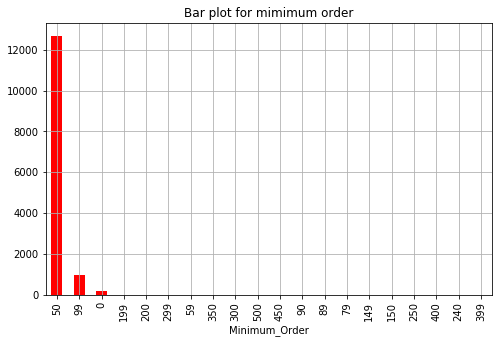

In [47]:
data['Minimum_Order'].value_counts().plot(kind='bar',figsize=(8,5),grid=True,color='red')
plt.xticks(rotation=90)
plt.xlabel('Minimum_Order')
plt.title('Bar plot for mimimum order')
plt.show()

In [48]:
# Minimum order of Rs50 is maximum in count.

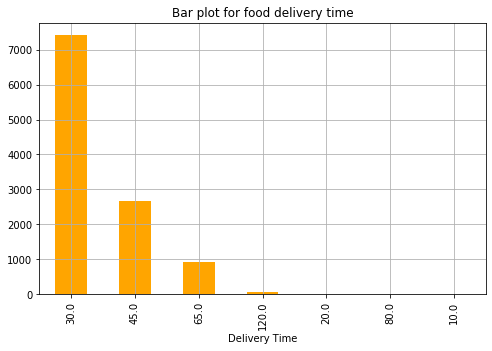

In [49]:
data['Delivery_Time'].value_counts().plot(kind='bar',figsize=(8,5),grid=True,color='orange')
plt.xlabel('Delivery Time')
plt.title('Bar plot for food delivery time')
plt.show()

In [50]:
#Maximum food delivery time is 30.

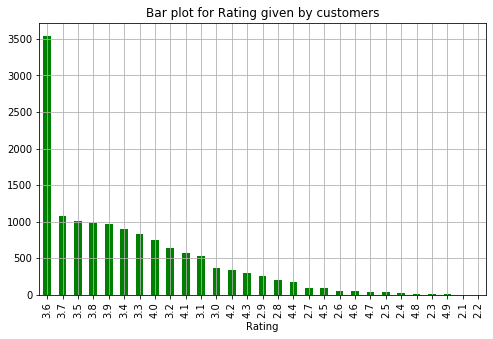

In [51]:
data['Rating'].value_counts().plot(kind='bar',figsize=(8,5),grid=True,color='green')
plt.xlabel('Rating')
plt.title('Bar plot for Rating given by customers')
plt.show()

In [52]:
#Maximum rating given is 3.6

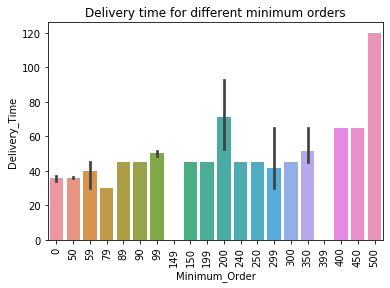

In [53]:
sns.barplot(data['Minimum_Order'],data['Delivery_Time'])
plt.xticks(rotation=90)
plt.title("Delivery time for different minimum orders")
plt.show()

In [54]:
# Delivery time of minimum order=500 is maximum

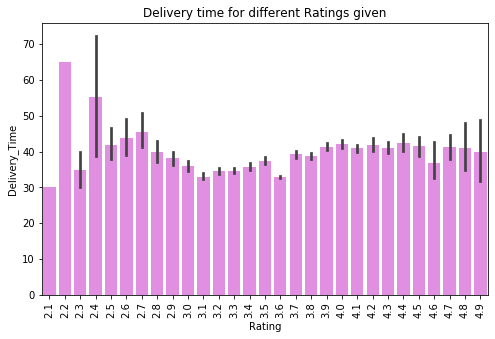

In [55]:
plt.figure(figsize=(8,5))
sns.barplot(data['Rating'],data['Delivery_Time'],color='violet')
plt.xticks(rotation=90)
plt.title("Delivery time for different Ratings given")
plt.show()

In [56]:
data['City'].value_counts()

noida              2647
pune               2474
delhi              1433
bangalore          1158
mumbai cst area     825
mumbai              711
kolkata             678
gurgoan             611
timarpur            602
whitefield          585
india gate          504
marathalli          444
maharashtra         379
hyderabad           371
gurgaon             323
begumpet             93
electronic city      30
Name: City, dtype: int64

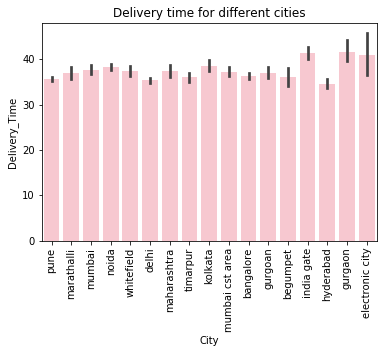

In [57]:
sns.barplot(data['City'],data['Delivery_Time'],color='pink')
plt.xticks(rotation=90)
plt.title("Delivery time for different cities")
plt.show()

In [58]:
#Maximum food delivery time is in Gurgaon and electronic city

------------------------------------

In [59]:
#Applying one hot encoding for city variable

In [60]:
enc = OneHotEncoder(handle_unknown='ignore')

In [61]:
data3=pd.DataFrame(enc.fit_transform(data[['City']]).toarray())

In [62]:
data=data.join(data3)

In [63]:
# Applying CountVectorizer for cuisine variable

In [64]:
vectorizer = CountVectorizer()
v = vectorizer.fit_transform(data['Cuisines']).toarray()
ft = vectorizer.get_feature_names()
cuisines = pd.DataFrame(v, columns= ft)

In [65]:
final_data=data.join(cuisines)

In [66]:
#Dropping Locality as it is of no relevance to predict the target variable

In [67]:
final_data.drop(['Cuisines','City','Locality'],axis=1,inplace=True)

In [68]:
train=final_data[final_data['Delivery_Time'].notnull()]

In [69]:
test=final_data[final_data['Delivery_Time'].isnull()]

In [70]:
X=train.drop('Delivery_Time',axis=1)
y=train[['Delivery_Time']]
Xt=test.drop('Delivery_Time',axis=1)

In [71]:
#Scaling features using Standard Scaler

In [72]:
ss=StandardScaler()
X_scaled=ss.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled,columns=X.columns)
Xt_scaled=ss.transform(Xt)
Xt_scaled=pd.DataFrame(Xt_scaled,columns=Xt.columns)

### Model Building 

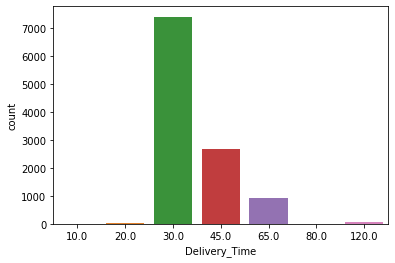

In [73]:
sns.countplot(final_data['Delivery_Time'])
plt.show()

In [74]:
# Clearly there is a high imbalance
# Taking Random Forest Classifier as a base model with F1-micro as a metric

In [75]:
#Train and Validation datasets

In [76]:
import random

In [77]:
random.seed(1)

In [78]:
X_train,X_valid,y_train,y_valid=train_test_split(X_scaled,y,test_size=0.3,random_state=0)

<IPython.core.display.Javascript object>

In [79]:
rf=RandomForestClassifier(n_estimators=100)

In [80]:
model=rf.fit(X_train,y_train)

In [81]:
y_pred=rf.predict(X_valid)

In [82]:
f1_score(y_valid,y_pred,average='micro')

0.78552117753079

In [83]:
# Customised grid search cv

In [84]:
f1_avg=[]
f1_var=[]
estimator=[]
for i in np.arange(1,50):
    for j in ['gini','entropy']:
        model=RandomForestClassifier(criterion=j,n_estimators=i,random_state=0)
        kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
        f1 = model_selection.cross_val_score(model, X_train,y_train,cv=kfold,scoring='f1_micro')
        f1_avg.append(1-np.mean(f1))
        f1_var.append(np.var(f1,ddof=1))
        estimator.append([i,j])

In [85]:
score=pd.DataFrame({'bias_error':f1_avg,'variance_error':f1_var,'n_estimator':estimator})
print(score[score['variance_error']==score['variance_error'].min()])
print(score[score['bias_error']==score['bias_error'].min()])

    bias_error  variance_error    n_estimator
37      0.2349        0.000004  [19, entropy]
    bias_error  variance_error    n_estimator
81    0.225628         0.00003  [41, entropy]


In [86]:
f1_score=[]
model=RandomForestClassifier(criterion='entropy',n_estimators=26)
kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
f1 = model_selection.cross_val_score(model,X_train,y_train,cv=kfold,n_jobs=-1,scoring='f1_micro')
f1_score.append(round(f1.mean(),5))
f1_score

[0.77334]

In [87]:
#Boosted Random Forest to reduce bias error

In [88]:
RF=RandomForestClassifier(criterion='entropy',n_estimators=26)

In [89]:
f1_avg=[]
f1_var=[]
estimator=[]
for i in np.arange(1,50):
    model=AdaBoostClassifier(base_estimator=RF,n_estimators=i,random_state=0)
    kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
    f1 = model_selection.cross_val_score(model, X_train,y_train,cv=kfold,scoring='f1_micro')
    f1_avg.append(1-np.mean(f1))
    f1_var.append(np.var(f1,ddof=1))
    estimator.append(i)

In [90]:
score=pd.DataFrame({'bias_error':f1_avg,'variance_error':f1_var,'n_estimator':estimator})
print(score[score['variance_error']==score['variance_error'].min()])
print(score[score['bias_error']==score['bias_error'].min()])

   bias_error  variance_error  n_estimator
2     0.22859        0.000002            3
    bias_error  variance_error  n_estimator
12    0.224855         0.00003           13


In [91]:
f1_score=[]
model=AdaBoostClassifier(base_estimator=RF,n_estimators=11,random_state=0)
kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
f1 = model_selection.cross_val_score(model,X_train,y_train,cv=kfold,n_jobs=-1,scoring='f1_micro')
f1_score.append(round(f1.mean(),5))
f1_score

[0.77463]

Final score on validation dataset: 0.77463

------------------------------------------------------------------

In [92]:
#Final check on testing dataset

In [93]:
RF=RandomForestClassifier(criterion='entropy',n_estimators=12)

In [94]:
model=AdaBoostClassifier(base_estimator=RF,n_estimators=41,random_state=0)

In [95]:
model.fit(X_scaled,y)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                    

In [96]:
y_pred=model.predict(Xt_scaled)

In [97]:
y_pred

array([30., 30., 30., ..., 45., 45., 65.])

In [98]:
y1=y_pred.astype(int)

In [99]:
y1=y1.astype(str) 
for i in range(len(y1)):
    y1[i] = y1[i]+" minutes"

In [100]:
df = pd.DataFrame (y1,columns=['Delivery_Time'])
df.to_excel("Submission2.xlsx",index = False)

Final score on test dataset: 0.79524

-------------------------------------------